# Binding distance Analysis
In this example noteboo>k a binding distance analysis will be shown and explained step by step. \
To start such an analysis, a market basket analysis is required first. Since the same data as in the [TFBS from motif](./TFBS_from_motifs.ipynb) notebook is used, the prerequisite steps will be encapsulated. \
For more details on how to perform the market basket step please have a look at the [TFBS from motif](./TFBS_from_motifs.ipynb) or [predefined TFBS](./Predefined_TFBS.ipynb) examples.  

## Content: 
- [Prepare object](#Prepare-GM12878-CombObj) 
- [Select rules](#Selecting-rules)
- [Automated analysis](#Method-1:-Automated-analysis)
- [Step-by-step:](#Method-2:-Step-by-Step-Analysis)
    1. [Create object](#1.-Create-a-distance-object)
        - [Anchor mode](#Anchor-mode)
    2. [Count distances](#2.-Distance-counting)
    3. [Smoothing counts](#3.-Smoothing-counts)
    4. [Linear regression](#4.-Linear-regression)
    5. [Correct background](#5.-Background-correction)
    6. [Analyse signal](#6.-Analyse-signal)
        1. [Median - Under construction](#5.A.-Median)
        2. [Zscore](#5.B.-Zscore)
- [Further downstream analysis](#Further-downstream-analysis)
    1. [Analyzing hubs](#1.-Analyzing-hubs)
    2. [Signal classification](#2.-Signal-classification)
        


<a id = prep></a>

## Prepare GM12878 CombObj

In [1]:
import tfcomb.objects

C = tfcomb.objects.CombObj()
C.TFBS_from_motifs(regions="../data/GM12878_hg38_chr4_ATAC_peaks.bed", 
                   motifs="../data/HOCOMOCOv11_HUMAN_motifs.txt",
                   genome="../data/hg38_chr4.fa.gz", 
                   threads=4)
C.count_within(max_overlap=0.0, threads=4)
C.market_basket()
C.rules.head()

INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 18%
INFO: Progress: 27%
INFO: Progress: 36%
INFO: Progress: 45%
INFO: Progress: 55%
INFO: Progress: 64%
INFO: Progress: 74%
INFO: Progress: 82%
INFO: Progress: 91%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 118527 TFBS (401 unique names) within given regions
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 16%
INFO: Progress: 24%
INFO: Progress: 32%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 66%
INFO: Progress: 74%
INFO: Progress: 82%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules


,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
SP2-SP3,SP2,SP3,1403,1906,1556,0.814688,83.303857
SP3-SP2,SP3,SP2,1403,1556,1906,0.814688,83.303857
SP1-SP2,SP1,SP2,1328,1507,1906,0.783574,66.253261
SP2-SP1,SP2,SP1,1328,1906,1507,0.783574,66.253261
ZNF121-ZNF770,ZNF121,ZNF770,966,884,1788,0.768364,83.008392



## Selecting rules

Due to the way the market basket analysis is working, the C.rules result table contains entries for every transcription factor combination present in the data. \
For a binding analysis not all of these rules are of particular interest. In this notebook the method _.select_significant_rules()_ is used to filter rules of interest. For more details on rule selection please refer to the example notebook [Select rules](./Select_rules.ipynb).


INFO: x_threshold is None; trying to calculate optimal threshold
INFO: y_threshold is None; trying to calculate optimal threshold
INFO: Creating subset of TFBS and rules using thresholds


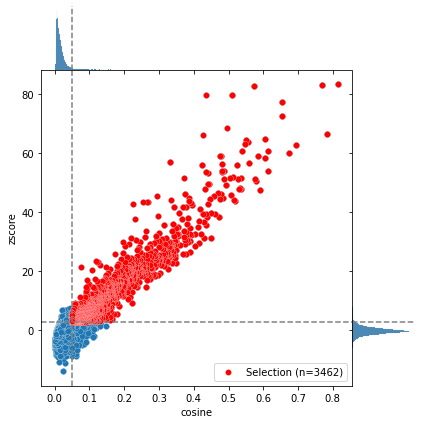

In [2]:
selection = C.select_significant_rules()

<a id="automated"></a>

## Method 1: Automated analysis

There are two different ways to run this analysis. The automated way will be shown in this chapter. Followed by an in depth guide showing the analysis step by step in the next chapter.  \
Here we will start with the __automated__ analysis for __all__ selected rules.  

In [3]:
selection.analyze_distances(threads=6) # adjust threads if needed

INFO: DistObject successfully created! It can be accessed via combobj.distObj
INFO: Calculating distances
INFO: Done finding distances! Results are found in .distances
INFO: Run .linregress_all() to fit linear regression
INFO: Smoothing signals with window size 3
INFO: Fitting linear regression. With number of threads: 6
INFO: Linear regression finished! Results can be found in .linres
INFO: Correcting background with 6 threads.
INFO: Background correction finished! Results can be found in .corrected
INFO: Analyzing Signal with threads 6
INFO: Done analyzing signal. Results are found in .peaks


In [4]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF121-ZNF770,ZNF121,ZNF770,26,4.185751,4.633789,2,966,290,30.020704,[25;27]
ZNF121-ZNF770,ZNF121,ZNF770,58,3.905876,4.331113,2,966,273,28.260870,[57;59]
ZNF121-ZNF770,ZNF121,ZNF770,66,2.096374,2.350128,2,966,160,16.563147,[65;67]


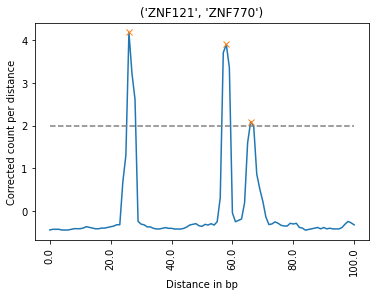

In [5]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="signal")

For an explaination of the results please refere to the in depth guide below.

<a id="sbs"></a>

## Method 2: Step-by-Step Analysis

Besides the automated way, the analysis can be done __step-by-step__. This chapter is an detailed guide, covering all 5 major steps.

<a id="1"></a>

### 1. Create a distance object

The binding distance analysis can be started from within any _combObj_. In this example the appropiate object is called __selection__, since we only want to use __significant__ rules, not all. The analysis can also be done without pre selection.

In [6]:
selection.create_distObj()

INFO: DistObject successfully created! It can be accessed via combobj.distObj


As stated in the information message, the distObj should be created successfully and filled with all important information to start the distance analysis. This includes parameters set for the market masket analysis. 

In [7]:
selection.distObj

The 3792 rules (market basket results) selected earlier by _select.significant_rules()_ are automatically passed to the distance object during creation:

In [8]:
selection.distObj.rules

,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
SP2-SP3,SP2,SP3,1403,1906,1556,0.814688,83.303857
SP3-SP2,SP3,SP2,1403,1556,1906,0.814688,83.303857
SP1-SP2,SP1,SP2,1328,1507,1906,0.783574,66.253261
SP2-SP1,SP2,SP1,1328,1906,1507,0.783574,66.253261
ZNF121-ZNF770,ZNF121,ZNF770,966,884,1788,0.768364,83.008392
...,...,...,...,...,...,...,...
YY1-NRF1,YY1,NRF1,7,114,169,0.050432,5.318021
FOSL2-JUN,FOSL2,JUN,13,263,253,0.050397,3.850134
JUN-FOSL2,JUN,FOSL2,13,253,263,0.050397,3.850134
USF2-WT1,USF2,WT1,18,78,1636,0.050389,3.104862


To unify the analysis steps between the market basket and the binding distance ones, the parameters for the 
>1. _minimal distance_
2. _maximal distance_
3. _maximal allowed overlap_ 
4. _directionality_ 
5. _anchor_

will be set automatically when creating the distance object according to the values used for the _market basket analysis_ step. 

In [9]:
selection.distObj.max_overlap

0.0

<a id="2"></a>

### 2. Distance counting

After creating the distObj the first step is to count the distances. This will be done with .count_distances().
In this step it is important to decide if the directionality should be taken into account. 

Internally, __Normalization__ is done the following way (min_max normalization):

\begin{equation}
\frac{signal_i - min(signal)}{max(signal)-min(signal}
\end{equation}

If __directionality__ is taken into account the position of the transcription factors do matter. This means there is a difference between _TFA -> TFB_ and _TFB -> TFA_ (compare [Directionality analysis](./Directionality_analysis.ipynb) notebook). Otherwise _TFA -> TFB_ and _TFB -> TFA_ are the same.
 
Per default the __directionality__ decision __is copied__ (None) from the market basket step.

In [10]:
selection.distObj.count_distances(directional=None)

INFO: Calculating distances
INFO: Done finding distances! Results are found in .distances
INFO: Run .linregress_all() to fit linear regression


In [11]:
selection.distObj.distances

,TF1,TF2,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
SP2-SP3,SP2,SP3,1,27,16,13,18,27,16,19,...,14,8,9,10,16,7,19,9,10,13
SP3-SP2,SP3,SP2,1,27,16,13,18,27,16,19,...,14,8,9,10,16,7,19,9,10,13
SP1-SP2,SP1,SP2,11,7,10,7,15,13,14,19,...,8,14,10,16,9,11,6,13,9,14
SP2-SP1,SP2,SP1,11,7,10,7,15,13,14,19,...,8,14,10,16,9,11,6,13,9,14
ZNF121-ZNF770,ZNF121,ZNF770,0,0,1,0,0,0,0,0,...,3,0,1,2,0,1,4,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YY1-NRF1,YY1,NRF1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOSL2-JUN,FOSL2,JUN,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JUN-FOSL2,JUN,FOSL2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USF2-WT1,USF2,WT1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Normalized distances are seen in .normalized:

In [12]:
selection.distObj.normalized.head()

,TF1,TF2,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
SP2-SP3,SP2,SP3,0.000000,1.000000,0.576923,0.461538,0.653846,1.000000,0.576923,0.692308,...,0.500000,0.269231,0.307692,0.346154,0.576923,0.230769,0.692308,0.307692,0.346154,0.461538
SP3-SP2,SP3,SP2,0.000000,1.000000,0.576923,0.461538,0.653846,1.000000,0.576923,0.692308,...,0.500000,0.269231,0.307692,0.346154,0.576923,0.230769,0.692308,0.307692,0.346154,0.461538
SP1-SP2,SP1,SP2,0.318182,0.136364,0.272727,0.136364,0.500000,0.409091,0.454545,0.681818,...,0.181818,0.454545,0.272727,0.545455,0.227273,0.318182,0.090909,0.409091,0.227273,0.454545
SP2-SP1,SP2,SP1,0.318182,0.136364,0.272727,0.136364,0.500000,0.409091,0.454545,0.681818,...,0.181818,0.454545,0.272727,0.545455,0.227273,0.318182,0.090909,0.409091,0.227273,0.454545
ZNF121-ZNF770,ZNF121,ZNF770,0.000000,0.000000,0.004608,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013825,0.000000,0.004608,0.009217,0.000000,0.004608,0.018433,0.023041,0.023041,0.009217


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the distances in bp
- __rows__: each row representing one rule (pair) with the corresponding results

<a id="neg"></a>

#### negative distances
Negative distances indicate overlapping. Caveat: this is basepair resolution and strongly dependend on motif length. \
Negative distance can occur if the distance anchor is set to _inner_ mode (see [Anchor mode](#Anchor-mode)) and overlapping is allowed. 


<a id="anchor"></a>

#### Anchor mode

TFCOMB distance analysis supports three different anchor modes: _inner_ , _outer_ and _center_. The recommended mode is __inner__. 

#TODO: Insert better anchor explanation (with graphic, formular etc.)
1. inner (default, recommented) is the distance *between* the transcription factors, it is measures as _start(transcription factor B) - end(transcription factor A)_. If for example transcription factor B is directly adjacent to Transcription factor A, the difference will be zero.
2. center is the distance measured from mid of transcription factor to mid of transcription factor
3. outer (uncommonly used) is the distance measured including both transcription factors. _end(transcription factor B) - start(transcription factor A)_

#### directionality
Since we didn't count directional, the values for the pairs TF1-TF2 and TF2-TF1 should be equal.For example in the DataFrame above the results for _ZNF121_-_ZNF770_ are the same as for _ZNF770_-_ZNF121_. This is not true if directionality is considered. 

__Note:__ If directionality is not considered, the duplicates can be filtered with .simplify_rules()


#### plotting
There are different ways to plot the distance distribution, you can for example create a kernel density estimate (KDE) plot or a histogram of the distribution.

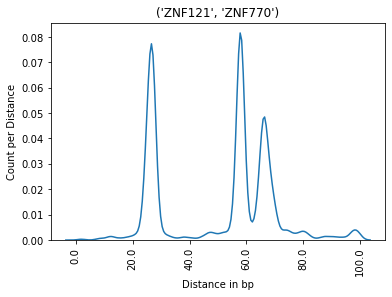

In [13]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="density")

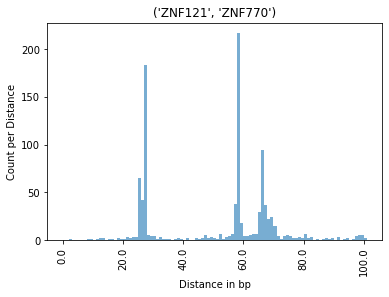

In [14]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="hist")

For __both__ plots the __x-axis__ shows the distance in bp. \
<a id="dist"></a>
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
For the __y-axis__ of the __kde plot__ the density estimation is shown. \
For the __y-axis__ of the __histogram__ the counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for all distances for the shown pair. 

<a id="3"></a>

### 3. Smoothing counts 

In order to collect distances from more than one basepair, e.g. in a window, it is possible to smooth the counted distances. This is done using the function .smooth() of the distObj:

In [15]:
selection.distObj.smooth(window_size=3)

INFO: Smoothing signals with window size 3


The smoothed (min-max-scaled) distances are visible in the .smoothed variable:

In [16]:
selection.distObj.smoothed.head()

,TF1,TF2,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
SP2-SP3,SP2,SP3,0.333333,0.525641,0.679487,0.564103,0.705128,0.743590,0.756410,0.679487,...,0.487179,0.358974,0.307692,0.410256,0.384615,0.500000,0.410256,0.448718,0.371795,0.423077
SP3-SP2,SP3,SP2,0.333333,0.525641,0.679487,0.564103,0.705128,0.743590,0.756410,0.679487,...,0.487179,0.358974,0.307692,0.410256,0.384615,0.500000,0.410256,0.448718,0.371795,0.423077
SP1-SP2,SP1,SP2,0.257576,0.242424,0.181818,0.303030,0.348485,0.454545,0.515152,0.681818,...,0.257576,0.303030,0.424242,0.348485,0.363636,0.212121,0.272727,0.242424,0.363636,0.378788
SP2-SP1,SP2,SP1,0.257576,0.242424,0.181818,0.303030,0.348485,0.454545,0.515152,0.681818,...,0.257576,0.303030,0.424242,0.348485,0.363636,0.212121,0.272727,0.242424,0.363636,0.378788
ZNF121-ZNF770,ZNF121,ZNF770,0.000000,0.001536,0.001536,0.001536,0.000000,0.000000,0.000000,0.001536,...,0.004608,0.006144,0.004608,0.004608,0.004608,0.007680,0.015361,0.021505,0.018433,0.013825


<a id="4"></a>

### 4. Linear regression

To separate the signal from the background noise a linear regression for every signal needs to be fitted next. The result of the fitted line for every pair can be found in the .linres attribute of the distance object.

In [17]:
selection.distObj.linregress_all()

INFO: Fitting linear regression. With number of threads: 1
INFO: Linear regression finished! Results can be found in .linres


In [18]:
selection.distObj.linres

,TF1,TF2,Linear Regression
MBD2-MAZ,MBD2,MAZ,"(-0.0011706464764123473, 0.23675014560279556, ..."
KLF3-HIF1A,KLF3,HIF1A,"(0.0006988934187536402, 0.0739662201514269, 0...."
KLF5-ZBTB14,KLF5,ZBTB14,"(-0.0001203649776742379, 0.0753251795767812, -..."
MECP2-SP4,MECP2,SP4,"(-0.0004294312290718571, 0.2769171094210535, -..."
E2F6-MECP2,E2F6,MECP2,"(-7.247785553610979e-05, 0.14223775691695412, ..."
...,...,...,...
ZBTB14-ZBTB17,ZBTB14,ZBTB17,"(-0.0002834401378768598, 0.1065812500801579, -..."
SP2-ZNF320,SP2,ZNF320,"(-0.00021452145214521457, 0.23597359735973597,..."
ZNF121-ZNF394,ZNF121,ZNF394,"(-0.003268969486093457, 0.250272543036667, -0...."
TFAP2B-ZBTB17,TFAP2B,ZBTB17,"(-0.0019860221316249267, 0.27256843331391967, ..."


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the linear regression object
- __rows__: each row representing one rule (pair) with the corresponding results

The fitted linear regression line can be plotted with the .plot() command. 

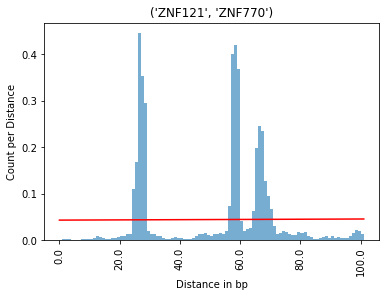

In [19]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="linres")

On the __x-axis__ on this plot the distance in bp is shown.\
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the histogram the counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for alle distances for the shown pair (see [Distance counting](#2.-Distance-counting) for details on how normalization is done). 

The __red line__ indicates the linear regression line which was fitted during this step. 

<a id="5"></a>

### 5. Background correction

Based on the linear regression, the background needs to be corrected. Therefore the linear regression is subtracted from the signal. 

In [20]:
selection.distObj.correct_all()

INFO: Correcting background with 1 threads.
INFO: Background correction finished! Results can be found in .corrected


In [21]:
selection.distObj.corrected

,TF1,TF2,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
MBD2-MAZ,MBD2,MAZ,-0.23675,-0.068913,0.098924,0.266762,0.101266,0.102436,-0.06306,-0.061889,...,0.203112,0.037616,-0.12788,-0.126709,0.041128,0.042299,0.043469,-0.122027,-0.120856,-0.119685
KLF3-HIF1A,KLF3,HIF1A,0.259367,0.258668,0.257969,-0.076063,-0.076762,-0.077461,-0.07816,-0.078858,...,-0.137566,-0.138264,-0.138963,-0.139662,-0.140361,0.192273,0.524908,0.524209,0.190177,-0.143856
KLF5-ZBTB14,KLF5,ZBTB14,0.258008,0.091462,-0.075084,-0.074964,-0.074844,-0.074723,0.092064,0.092184,...,-0.064372,-0.064252,-0.064131,-0.064011,0.102776,0.269563,0.269684,0.103137,-0.063409,-0.063289
MECP2-SP4,MECP2,SP4,0.123083,0.056846,-0.076058,-0.142295,-0.141866,0.058563,0.125659,0.192756,...,0.228828,0.029257,0.096353,0.030116,-0.102788,-0.102358,-0.168596,-0.034833,-0.10107,-0.100641
E2F6-MECP2,E2F6,MECP2,-0.031127,-0.031054,-0.030982,-0.030909,-0.030837,-0.030764,0.19153,0.302714,...,-0.024531,-0.024459,-0.135497,-0.024314,0.08687,0.086942,-0.024096,-0.024024,0.198271,0.420566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZBTB14-ZBTB17,ZBTB14,ZBTB17,0.115641,0.115924,0.33843,0.116491,0.116775,0.005947,0.117342,0.117625,...,0.252545,0.252829,0.253112,-0.079938,-0.079654,-0.079371,-0.079088,-0.078804,-0.078521,-0.078237
SP2-ZNF320,SP2,ZNF320,-0.069307,-0.152426,-0.152211,0.01467,0.014884,0.098432,-0.06802,-0.067805,...,0.033548,-0.132904,-0.13269,-0.132475,-0.132261,-0.048713,-0.131832,0.03505,-0.048069,-0.047855
ZNF121-ZNF394,ZNF121,ZNF394,-0.250273,-0.247004,-0.218094,-0.214825,-0.134633,0.022483,0.359085,0.618764,...,0.047204,0.050473,0.053742,0.057011,0.06028,0.063549,0.066817,0.070086,0.098996,0.127906
TFAP2B-ZBTB17,TFAP2B,ZBTB17,-0.105902,-0.103916,-0.10193,0.066723,0.235376,0.570695,0.239348,0.074667,...,0.074826,-0.089854,-0.087868,-0.085882,-0.083896,-0.08191,0.086742,0.088728,0.090714,-0.073966


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the __corrected__ distances in bp 
- __rows__: each row representing one rule (pair) with the corresponding results

The corrected distribution can be plotted with the .plot() command. 

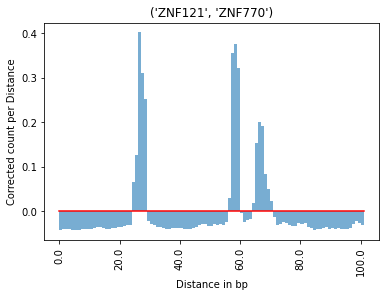

In [22]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="corrected")

This Plot shows the __corrected__ signal.

On the __x-axis__ the distance in bp is shown. \
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the histogram the __corrected__ counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for all distances for the shown pair (see [Distance counting](#2.-Distance-counting) for details on how normalization is done).

Since we subtracted the linear regression line from the signal, the red line should always be zero with the signal moving around.

<a id="6"></a>

### 6. Analyse signal 

As a last step, the corrected signal can now be analyzed. Peaks will be called with [_scipy.signal.find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). Three different threshold modes are available: 

1. "median"
2. "zscore" 
3. (number)

#TODO: fix median mode and update example FOR NOW USE ZSCORE \
The two modes __median__ and __zscore__ will be shown in the following sections. If a number is passed instead of a mode, the number will be directly passed to [_scipy.signal.find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

<a id="zscore"></a>

#### 6.B. Zscore

If prominence is set to __zscore__ the prominence threshold is set to the zscore (of the corrected signal) for each signal. Aside from that the signal is translated from counts per distance to signal per distance. The resulting signal preserves its shape, but mind the change of the unit. \
With the parameter _stringency_ the zscore threshold is set. For example if stringency is 2, the threshold prominence (for the score translated signal) will be a zscore of two. 

In [23]:
selection.distObj.analyze_signal_all(prominence="zscore", stringency=2, threads=6)
selection.distObj.peaks

INFO: Analyzing Signal with threads 6
INFO: Done analyzing signal. Results are found in .peaks


,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF394-SMARCA5,ZNF394,SMARCA5,5,6.587455,7.522742,2,71,24,33.802817,[4;6]
SMARCA5-ZNF394,SMARCA5,ZNF394,5,6.587455,7.522742,2,71,24,33.802817,[4;6]
ZNF582-SMARCA5,ZNF582,SMARCA5,3,6.381163,7.338053,2,60,21,35.000000,[2;4]
SMARCA5-ZNF582,SMARCA5,ZNF582,3,6.381163,7.338053,2,60,21,35.000000,[2;4]
SMARCA5-POU3F2,SMARCA5,POU3F2,9,5.878035,7.127181,2,90,18,20.000000,[8;10]
...,...,...,...,...,...,...,...,...,...,...
FEV-ZNF281,FEV,ZNF281,0,2.004015,2.004015,2,19,2,10.526316,[0;1]
KLF9-ZNF263,KLF9,ZNF263,0,2.003675,2.003675,2,127,5,3.937008,[0;1]
ZNF263-KLF9,ZNF263,KLF9,0,2.003675,2.003675,2,127,5,3.937008,[0;1]
KLF12-RXRA,KLF12,RXRA,46,2.112785,2.001147,2,32,3,9.375000,[45;47]


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by 
    1. __prefered distance__ in bp 
    2. __peak heights__ height of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    3. __prominence__ prominence of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    4. __prominence threshold__ minimum prominence needed to be considered as peak (in this example the [zscore](#5.B.-Zscore) of the signal).
    
    
- __rows__: each row representing one rule (pair) at a distinct prefered binding distance with the corresponding results

The signal can be plotted with the .plot() command.

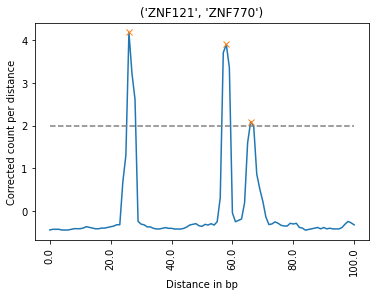

In [24]:
selection.distObj.plot(("ZNF121", "ZNF770"), method="signal")

This plot shows the __corrected__ signal with the __called peaks__, indicated by a cross.

On the __x-axis__ the distance in bp is shown. \
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the plot the calculated __zscore__ per distance is shown. 

The __grey dottet line__ shows the decision boundary (in this example a zscore of 2)

In [25]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Threshold,TF1_TF2_count,Distance_count,Distance_percent,Distance_window
ZNF121-ZNF770,ZNF121,ZNF770,26,4.185751,4.633789,2,966,290,30.020704,[25;27]
ZNF121-ZNF770,ZNF121,ZNF770,58,3.905876,4.331113,2,966,273,28.260870,[57;59]
ZNF121-ZNF770,ZNF121,ZNF770,66,2.096374,2.350128,2,966,160,16.563147,[65;67]


The results in the .peaks table and the plot matches. For this _ZNF121_-_ZNF770_ 3 peaks were found, which also can be seen in the plot at positions: 
> 1. distance:  26 
2. distance: 58 
3. distance: 66 

Meaning the zscore threshold with stringency of 2 identifies 3 different preferred distances for this pair. Please note, that the height of the distances differ!

----------------

## Further downstream analysis

### 1.  Analyzing hubs
This function allows to summarize the number of different partners (with at least one peak) each transcription factor has.

In [26]:
selection.distObj.analyze_hubs().sort_values()

ZIC3       1
NFKB1      1
ZNF768     1
SPI1       1
PRDM1      1
          ..
PATZ1     78
SP3       79
KLF6      79
SP1       86
SP2       90
Length: 196, dtype: int64

### 2. Signal classification
This function allows to classify the pairs (in .distance DataFrame) wheather the signal is peaking or not.

In [27]:
selection.distObj.classify_rules()
selection.distObj.datasource.sort_values(by="isPeaking")

INFO: classifying rules
INFO: classifcation done


,TF1,TF2,0,1,2,3,4,5,6,7,...,92,93,94,95,96,97,98,99,100,isPeaking
ZNF281-GABPA,ZNF281,GABPA,-0.095515,-0.095486,-0.095457,-0.095428,-0.095399,0.237964,0.237993,0.238022,...,0.07383,-0.092807,0.073889,0.240584,0.240613,0.073976,-0.092662,-0.092632,-0.092603,False
ZNF263-E2F3,ZNF263,E2F3,-0.089691,-0.090076,-0.09046,-0.090844,0.075438,0.075053,0.074669,-0.092382,...,0.041611,-0.12544,-0.125824,-0.126209,-0.126593,-0.126977,0.039305,0.038921,0.038536,False
ZNF467-SP2,ZNF467,SP2,-0.168187,-0.167631,-0.078186,0.011259,0.034038,-0.076517,-0.098183,0.013484,...,-0.117011,-0.116455,0.106324,0.062436,0.062992,-0.003118,0.041882,0.042439,0.065217,False
SP3-WT1,SP3,WT1,-0.261194,-0.062862,-0.001785,0.059292,0.041938,0.083407,0.085661,0.048698,...,0.063783,-0.110434,-0.167004,-0.16475,-0.103673,0.016227,0.096912,0.138382,0.081812,False
MBD2-ZNF76,MBD2,ZNF76,-0.032615,-0.033547,-0.034479,-0.035411,-0.036342,-0.037274,-0.038206,-0.039138,...,-0.118346,-0.119278,0.213124,0.212192,0.21126,-0.123005,-0.123937,-0.124869,-0.125801,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF770-ZNF394,ZNF770,ZNF394,0.085932,0.082191,0.07845,0.044407,0.070969,0.067228,0.063487,0.059746,...,0.044805,0.131973,-0.114192,-0.027024,-0.061068,-0.064809,-0.189762,-0.223805,-0.257849,True
MYOG-SP1,MYOG,SP1,-0.13609,-0.026284,-0.027588,-0.028893,-0.141308,0.079609,0.189416,0.299222,...,-0.033891,0.075915,-0.0365,0.073306,0.072002,0.070697,0.069392,-0.043023,-0.155439,True
KLF1-ATF1,KLF1,ATF1,-0.117647,-0.116482,-0.115317,-0.114153,0.053679,0.054844,0.389342,0.22384,...,-0.010483,-0.009319,-0.008154,-0.006989,-0.005824,-0.004659,-0.003494,-0.00233,-0.001165,True
MECP2-ZNF341,MECP2,ZNF341,0.076102,-0.036135,-0.148372,-0.26061,-0.039513,-0.040639,-0.041765,-0.042891,...,-0.249712,-0.139727,-0.140853,-0.030868,-0.143105,-0.255342,-0.145357,-0.035372,0.074613,True


True means the signal has at least one peak found, false otherwise